## This is the post processing tool for microstate file. 

### Load the Library to read the input files.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ms_analysis as msa 
import math
%matplotlib inline

### This will read the microstate file pH5eH0ms.txt obtained from MCCE output.  Here file pH5eH0ms.txt means pH at 5.

In [2]:
mc = msa.MSout("../ms_out/pH5eH0ms.txt")

### We are intrested in the microstate enthalpy, count and microstate id. These quantities are saved in a list and list are sorted based enthalpy from lowest to highest 

In [3]:
ms_orig_lst = [[ms.E, ms.count, ms.state] for  ms in list((mc.microstates.values()))]
ms_orig_lst = sorted(ms_orig_lst, key = lambda x:x[0])

print(ms_orig_lst[:5])

[[-203.360062, 8, [1, 7, 20, 36, 42, 43, 46, 55, 58, 72, 79, 81, 83, 86, 92, 94, 104, 112, 116, 123, 125, 129, 132, 137, 146, 154, 160, 174, 185, 188, 198, 203, 211, 223, 228, 229, 233, 236, 245, 254, 260, 263, 283]], [-203.349625, 8, [1, 7, 20, 36, 42, 43, 46, 55, 58, 69, 79, 81, 83, 86, 92, 94, 104, 112, 116, 123, 125, 129, 132, 137, 146, 154, 160, 174, 185, 188, 198, 203, 211, 223, 228, 229, 233, 236, 245, 254, 260, 263, 283]], [-203.345627, 2, [1, 7, 20, 36, 42, 43, 46, 55, 58, 72, 79, 81, 83, 86, 92, 95, 104, 112, 116, 123, 125, 129, 132, 137, 146, 154, 160, 174, 185, 188, 198, 203, 211, 223, 228, 229, 233, 236, 245, 254, 260, 263, 283]], [-203.320267, 10, [1, 7, 20, 36, 42, 43, 46, 55, 58, 72, 79, 81, 83, 86, 92, 94, 104, 112, 116, 123, 125, 129, 132, 137, 146, 154, 162, 174, 185, 188, 198, 203, 211, 223, 228, 229, 233, 236, 245, 254, 260, 263, 283]], [-203.285995, 5, [1, 7, 20, 36, 42, 43, 46, 55, 58, 69, 79, 81, 83, 86, 92, 94, 104, 112, 116, 123, 125, 129, 132, 137, 146, 154, 

### Total number of count.

In [4]:
print(sum([x[1] for x in ms_orig_lst]))

1500000


### Main purpose of this method is to understand the charge. Let us convert the conformer id to the charge.

In [5]:
id_vs_charge = {}
for conf in msa.conformers:
    id_vs_charge[conf.iconf] = conf.crg

def convert_ms_crg(l, d):
    crg_lst =[[y[0], y[1], [convert_ms_crg(x, d) if isinstance(x, list) else d.get(x, x) for x in y[2]]] for y in l]
    return crg_lst

crg_orig_lst = convert_ms_crg(ms_orig_lst, id_vs_charge )
print(crg_orig_lst[:5])

[[-203.360062, 8, [1.0, 1.0, -1.0, 1.0, -1.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, -1.0]], [-203.349625, 8, [1.0, 1.0, -1.0, 1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, -1.0]], [-203.345627, 2, [1.0, 1.0, -1.0, 1.0, -1.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, -1.0]], [-203.320267, 10, [1.0, 1.0, -1.0, 1.0, -1.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, -1.0]], [-203.285995, 5, [1

### This is to plot the enthalpy distribution with considering count and witthout count

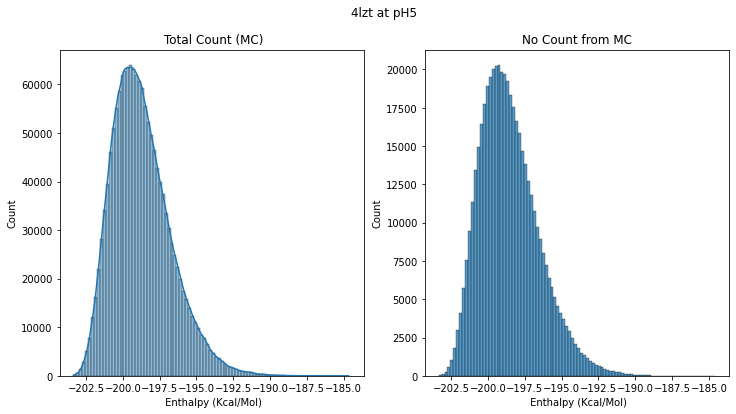

In [6]:
energy_lst_count =np.asarray([a for a,f in zip([x[0] for x in crg_orig_lst], [x[1] for x in crg_orig_lst]) for _ in range(f)])
energy_lst = np.asarray([x[0] for  x in crg_orig_lst])

fig = plt.figure(figsize = (12,6))
fig.suptitle("4lzt at pH5")

plt.subplot(121)
plt.title(' Total Count (MC)')
sns.histplot(energy_lst_count,binwidth=0.2, kde = True)
plt.xlabel(" Enthalpy (Kcal/Mol)")


plt.subplot(122)
sns.histplot(energy_lst, binwidth=0.2)
plt.title('No Count from MC')
plt.xlabel(" Enthalpy (Kcal/Mol)")
fig.savefig("enthalpy_dis.pdf", dpi = 600, bbox_inches = "tight")

### Free residues that is residues that are shown in the microstate list

In [7]:
free_residues = []
for res in mc.free_residues:
    free_residues.append(msa.conformers[res[0]].resid)
ms_free_residues = pd.DataFrame(free_residues,columns = ["Residue"])
ms_free_residues[:5]


,Residue
0,NTRA0001_
1,LYSA0001_
2,GLUA0007_
3,HISA0015_
4,ASPA0018_


### This is for the residues that are titrable but not microstate list.

In [8]:
fixed_resid = []
for conf in msa.conformers:
    if conf.resid not in free_residues:
        if conf.resid[:3] == "NTR" or conf.resid[:3] == "CTR" or conf.resid[:3] == "HIS" or conf.resid[:3] == "LYS" or conf.resid[:3] == "ARG" or conf.resid[:3] == "CYS" or conf.resid[:3] == "ASP" or conf.resid[:3] == "GLU" or conf.resid[:3] == "TYR":
            if conf.resid not in fixed_resid:
                fixed_resid.append(conf.resid)
    
print(fixed_resid[:5])

['ARGA0005_', 'LYSA0013_', 'ARGA0014_', 'ARGA0021_', 'TYRA0023_']


### In order to get the charge of microstate, it needs to consider the charge of free residues and fixed residues. so, this is to read the charge of fixed residues which is  here called as background charge.

In [9]:
def read_backcrg(fname, ph):
    fixed_resid_vs_crg = {} 
    lines = open(fname).readlines()[:-4]
    headline = lines.pop(0)
    fields = headline.split()
    t_type = fields[0].strip()
    t_points = [float(x) for x in fields[1:]]
    index_ph = t_points.index(float(ph)) + 1
    for line in lines:
        fields = line.split()
        if (fields[0][:3] + fields[0][4:]) in fixed_resid:
            fixed_resid_vs_crg[(fields[0][:3] + fields[0][4:])] = round(float(fields[index_ph]), 0)
    back_crg= round(sum(list(fixed_resid_vs_crg.values())),0)

    return back_crg, fixed_resid_vs_crg

### Select same ph as you load the miscrostate file to get the background charge. This will make the pandas data frame for fixed residues with the protonation state information.

## Note: Give same pH

In [10]:
fixed_sum_crg = read_backcrg("../sum_crg.out", 5)
fixed_residues_crg = pd.DataFrame(fixed_sum_crg[1].items(), columns=['Residue', 'crg'])
fixed_residues_crg[:5]

,Residue,crg
0,ARGA0005_,1.0
1,LYSA0013_,1.0
2,ARGA0014_,1.0
3,ARGA0021_,1.0
4,TYRA0023_,-0.0


### Since we have the large charge microstate files so this will give you  unique charge state, enthalpy range of that charge state and how many times that charge state appear in Monte Carlo run as count in all enthalpy range.

In [11]:
crg_all_count = {}
for array in crg_orig_lst:
    if tuple(array[2]) not in crg_all_count.keys():
        crg_all_count[(tuple(array[2]))] = [array[1], [array[0]]]
        
    else:
        crg_all_count[(tuple(array[2]))][0] += array[1]
        if len(crg_all_count[(tuple(array[2]))][1]) == 1:
            
            if array[0] < crg_all_count[(tuple(array[2]))][1][0]:
                crg_all_count[(tuple(array[2]))][1].insert(0, array[0])
                
            
            else:
                crg_all_count[(tuple(array[2]))][1].append(array[0])
                
        else:
            if array[0] < crg_all_count[(tuple(array[2]))][1][0]:
                del crg_all_count[(tuple(array[2]))][1][0]
                crg_all_count[(tuple(array[2]))][1].insert(0, array[0])
            elif array[0] > crg_all_count[(tuple(array[2]))][1][-1]:
                crg_all_count[(tuple(array[2]))][1].pop()
                crg_all_count[(tuple(array[2]))][1].append(array[0])
            else:
                continue
                
# make a list of count and charge microstate
all_crg_ms_unique  = []
all_count = []
energy_diff_all = []
for u,v in crg_all_count.items():
    all_crg_ms_unique.append(list(u))
    all_count.append(v[0])
    if len(v[1]) == 2:
        energy_diff_all.append(round(v[1][1]-v[1][0], 6))
    elif len(v[1]) == 1:
        energy_diff_all.append(0)
    else:
        print("error in dictionary")
# to check length of charge state and count 
print(len(all_crg_ms_unique) == len(energy_diff_all) == len(all_count))   
print(f" Total charge ms : {len(crg_orig_lst )}, Total Unique charge ms  {len(all_crg_ms_unique)}")              
# make the panda data frame and concatinate
# make panda series and save
all_crg_ms_lst = pd.DataFrame(all_crg_ms_unique).T
all_ms_count = pd.DataFrame(all_count,columns = ["Count"]).T
all_crg_ms_count_pd = pd.concat([all_crg_ms_lst.reindex(all_crg_ms_lst.index), all_ms_count])
all_crg_count_res_1 = pd.concat([ms_free_residues, all_crg_ms_count_pd.reindex(all_crg_ms_count_pd.index)], axis=1)
from numpy import inf
all_crg_count_res_1 = all_crg_count_res_1.fillna('Count')
# remove the non titrable residues
all_crg_count_res = all_crg_count_res_1.copy()
for x,y in all_crg_count_res.iterrows():
    if y['Residue'][:3] != "NTR" and y['Residue'][:3] != "CTR" and y['Residue'][:5] != "Count" and y['Residue'][:3] != "ASP" and y['Residue'][:3] != "GLU"\
       and y['Residue'][:3] != "LYS" and y['Residue'][:3] != "TYR" and  y['Residue'][:3] != "ARG" and y['Residue'][:3] != "CYS"and y['Residue'][:3] != "HIS":
        
        all_crg_count_res.drop([x], inplace = True)

all_crg_count_res = all_crg_count_res.set_index("Residue")
# sort based on the count
all_crg_count_res = all_crg_count_res.sort_values(by = "Count", axis = 1, ascending = False)
all_crg_count_res[:5]

True
 Total charge ms : 484152, Total Unique charge ms  147


,1,0,7,4,5,3,6,2,9,11,...,146,128,113,110,144,139,97,141,142,125
Residue,,,,,,,,,,,,,,,,,,,,,
NTRA0001_,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
LYSA0001_,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
GLUA0007_,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,...,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,0.0
HISA0015_,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
ASPA0018_,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0


### This will plot the  tautomer charge distribution of unqiue charge microstate based on the occupancy. Each dot are unique charge microstate and color coded based on the enthalpy difference of that microstate appear in Monte Carlo run. Total charge is sum of background and free charge.

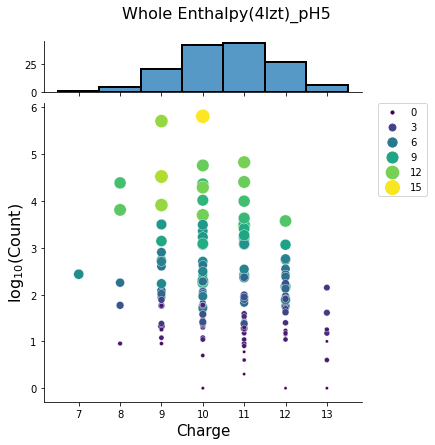

In [12]:
# which tautomer charge state is most populated. This includes the background charge also.
import seaborn as sns
import matplotlib.pyplot as plt
import math
%matplotlib inline
x_av = [sum(x) + fixed_sum_crg[0] for x in all_crg_ms_unique]
y_av = [math.log10(x) for x in all_count]
energy_diff_all_fl = [float(x) for x in energy_diff_all]
g1 = sns.JointGrid(marginal_ticks=True, height = 6)
ax = sns.scatterplot(x=x_av, y=y_av, hue = energy_diff_all_fl, palette = 'viridis', size = energy_diff_all_fl, sizes=(10, 200), ax=g1.ax_joint)
ax.set_xticks(range(int(min(x_av)), int(max(x_av)) + 1))
ax.set_xlabel("Charge",fontsize=15)
ax.set_ylabel("log$_{10}$(Count)",fontsize=16)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax2 = sns.histplot(x=x_av, linewidth=2,discrete=True, ax=g1.ax_marg_x)

ax2.set_ylabel(None,fontsize=16)
g1.ax_marg_y.set_axis_off()
g1.fig.subplots_adjust(top= 0.9)
g1.fig.suptitle('Whole Enthalpy(4lzt)_pH5', fontsize = 16)
g1.savefig("all_en_cr_ph5_vs_log(count).pdf", dpi = 600, bbox_inches = "tight");

### This is to get the unique charge microstate less or equal to  lowest enthalpy + 1.36 KCal/Mol

In [13]:
low_crg_ms = [[x[0], x[1], x[2]] for x in crg_orig_lst if x[0] <= (mc.lowest_E  + 1.36)]

low_crg_count = {}
for array in low_crg_ms :
    if tuple(array[2]) not in low_crg_count.keys():
        low_crg_count[(tuple(array[2]))] = array[1]
    else:
        low_crg_count[(tuple(array[2]))] += array[1]

# make a list of count and charge microstate
low_crg_ms_unique = []
low_count = []
for u,v in low_crg_count.items():
    low_crg_ms_unique.append(list(u))
    low_count.append(v)
print(f" Total charge ms : {len(low_crg_ms )}, Total Unique charge ms  {len(low_crg_ms_unique)}")
print(len(low_count))

# make panda series and save
low_crg_ms_lst = pd.DataFrame(low_crg_ms_unique).T
low_ms_count = pd.DataFrame(low_count,columns = ["Count"]).T
low_crg_ms_count_pd = pd.concat([low_crg_ms_lst.reindex(low_crg_ms_lst.index), low_ms_count])
low_crg_count_res_1 = pd.concat([ms_free_residues, low_crg_ms_count_pd.reindex(low_crg_ms_count_pd.index)], axis=1)
from numpy import inf
low_crg_count_res_1 = low_crg_count_res_1.fillna('Count')
# remove the non titrable residues
low_crg_count_res = low_crg_count_res_1.copy()
for x,y in low_crg_count_res.iterrows():
    if y['Residue'][:3] != "NTR" and y['Residue'][:5] != "Count" and y['Residue'][:3] != "CTR"and y['Residue'][:3] != "ASP" and y['Residue'][:3] != "GLU"\
       and y['Residue'][:3] != "LYS" and y['Residue'][:3] != "TYR" and  y['Residue'][:3] != "ARG" and y['Residue'][:3] != "CYS"and y['Residue'][:3] != "HIS":
        
        low_crg_count_res.drop([x], inplace = True)

low_crg_count_res = low_crg_count_res.set_index("Residue")
low_crg_count_res[:5]

 Total charge ms : 6116, Total Unique charge ms  2
2


,0,1
Residue,,
NTRA0001_,1.0,1.0
LYSA0001_,1.0,1.0
GLUA0007_,-1.0,-1.0
HISA0015_,1.0,1.0
ASPA0018_,-1.0,-1.0


### This is to get the unique charge microstate around +/- 0.5 pH unit ( +/- 0.68  Kcal/Mol) of average enthalpy.

In [14]:
av_crg_ms = [[x[0], x[1], x[2]] for x in crg_orig_lst if x[0] >= (mc.average_E  - 0.68) and  x[0] <= (mc.average_E  + 0.68)]

if len(av_crg_ms) < 10:
    print("less than ten microstate selected")

av_crg_count = {}
for array in av_crg_ms :
    if tuple(array[2]) not in av_crg_count.keys():
        av_crg_count[(tuple(array[2]))] = array[1]
    else:
        av_crg_count[(tuple(array[2]))] += array[1]

# make a list of count and charge microstate
av_crg_ms_unique = []
av_count = []
for u,v in av_crg_count.items():
    av_crg_ms_unique.append(list(u))
    av_count.append(v)
print(f" Total charge ms : {len(av_crg_ms )}, Total Unique charge ms  {len(av_crg_ms_unique)}")
print(len(av_count)) 

    
# make the panda data frame and concatinate
av_crg_ms_lst = pd.DataFrame(av_crg_ms_unique).T
av_ms_count = pd.DataFrame(av_count,columns = ["Count"]).T
av_crg_ms_count_pd = pd.concat([av_crg_ms_lst.reindex(av_crg_ms_lst.index), av_ms_count])
av_crg_count_res_1 = pd.concat([ms_free_residues, av_crg_ms_count_pd.reindex(av_crg_ms_count_pd.index)], axis=1)
from numpy import inf
av_crg_count_res_1 = av_crg_count_res_1.fillna('Count')
#remove the non titrable residues
av_crg_count_res = av_crg_count_res_1.copy()
for x,y in av_crg_count_res.iterrows():
    if y['Residue'][:3] != "NTR" and y['Residue'][:3] != "CTR" and y['Residue'][:5] != "Count" and y['Residue'][:3] != "ASP" and y['Residue'][:3] != "GLU"\
       and y['Residue'][:3] != "LYS" and y['Residue'][:3] != "TYR" and  y['Residue'][:3] != "ARG" and y['Residue'][:3] != "CYS"and y['Residue'][:3] != "HIS":
        
        av_crg_count_res.drop([x], inplace = True)

av_crg_count_res = av_crg_count_res.set_index("Residue")
# sort based on Count
av_crg_count_res = av_crg_count_res.sort_values(by = "Count", axis = 1, ascending = False)
av_crg_count_res[:5]


 Total charge ms : 129396, Total Unique charge ms  28
28


,1,0,2,3,9,7,5,6,4,10,...,20,21,23,18,16,22,26,27,24,25
Residue,,,,,,,,,,,,,,,,,,,,,
NTRA0001_,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
LYSA0001_,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
GLUA0007_,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
HISA0015_,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ASPA0018_,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,0.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0


### This is to get the unique charge microstate  of 1KT unit(1.36 Kcal/Mol) less or equal than highest enthalpy state.

In [15]:
high_crg_ms = [[x[0], x[1], x[2]] for x in crg_orig_lst if x[0] >= (mc.highest_E - 1.36)]


high_crg_count = {}
for array in high_crg_ms :
    if tuple(array[2]) not in high_crg_count.keys():
        high_crg_count[(tuple(array[2]))] = array[1]
    else:
        high_crg_count[(tuple(array[2]))] += array[1]

# make a list of count and charge microstate
high_crg_ms_unique = []
high_count = []
for u,v in high_crg_count.items():
    high_crg_ms_unique.append(list(u))
    high_count.append(v)
print(f" Total charge ms : {len(high_crg_ms )}, Total Unique charge ms  {len(high_crg_ms_unique)}")
print(len(low_count))

# make panda series and save
import pandas as pd
high_crg_ms_lst = pd.DataFrame(high_crg_ms_unique).T
high_ms_count = pd.DataFrame(high_count,columns = ["Count"]).T
high_crg_ms_count_pd = pd.concat([high_crg_ms_lst.reindex(high_crg_ms_lst.index), high_ms_count])
high_crg_count_res_1 = pd.concat([ms_free_residues, high_crg_ms_count_pd.reindex(high_crg_ms_count_pd.index)], axis=1)
from numpy import inf
high_crg_count_res_1 = high_crg_count_res_1.fillna('Count')
# remove the non titrable residues
high_crg_count_res = high_crg_count_res_1.copy()
for x,y in high_crg_count_res.iterrows():
    if y['Residue'][:3] != "NTR" and y['Residue'][:5] != "Count" and y['Residue'][:3] != "CTR"and y['Residue'][:3] != "ASP" and y['Residue'][:3] != "GLU"\
       and y['Residue'][:3] != "LYS" and y['Residue'][:3] != "TYR" and  y['Residue'][:3] != "ARG" and y['Residue'][:3] != "CYS"and y['Residue'][:3] != "HIS":
        
        high_crg_count_res.drop([x], inplace = True)

high_crg_count_res = high_crg_count_res.set_index("Residue")
high_crg_count_res[:5]

 Total charge ms : 4, Total Unique charge ms  2
2


,0,1
Residue,,
NTRA0001_,1.0,1.0
LYSA0001_,1.0,1.0
GLUA0007_,0.0,0.0
HISA0015_,0.0,1.0
ASPA0018_,-1.0,0.0


### Save all the pandas data frame.

In [16]:
# save all three data frames and non titrable residues charge information.
writer = pd.ExcelWriter('charge_ms_4lzt_pH5.xlsx', engine='xlsxwriter')
low_crg_count_res.to_excel(writer, sheet_name='low_crg_count_res')
av_crg_count_res.to_excel(writer, sheet_name='av_crg_count_res')
high_crg_count_res.to_excel(writer, sheet_name='high_crg_count_res')
fixed_residues_crg.to_excel(writer, sheet_name = 'fixed_residues_crg')
writer.save()
# Due to coulmn size issue in excel for large sytem. We save in csv format for all charge.                           
all_crg_count_res.to_csv('all_crg_count_res.csv', header = True)

### This is for the post processing of already save file. This is for to get the correlation matrix for residues. Here we plotting the correlation matrix if occupancy is atleast 0.01 i.e. 1%.

In [17]:
all_crg_count= pd.read_csv("all_crg_count_res.csv", index_col = 0)
all_crg_count_T = all_crg_count.T
all_crg_count_T["Occupancy"] = (all_crg_count_T.Count/sum(all_crg_count_T.Count)).round(3)
all_crg_count_T_filter = all_crg_count_T[all_crg_count_T['Occupancy'] >= 0.01]
all_crg_count_T_filter = all_crg_count_T_filter.iloc[:, :-2] 
all_crg_count_T_filter[:5]

Residue,NTRA0001_,LYSA0001_,GLUA0007_,HISA0015_,ASPA0018_,TYRA0020_,GLUA0035_,ASPA0048_,ASPA0052_,TYRA0053_,ASPA0066_,ASPA0087_,ASPA0101_,ASPA0119_,CTRA0129_
1,1.0,1.0,-1.0,1.0,-1.0,0.0,0.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0
0,1.0,1.0,-1.0,1.0,-1.0,0.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0
7,1.0,1.0,-1.0,1.0,-1.0,0.0,0.0,-1.0,-1.0,0.0,-1.0,-1.0,0.0,-1.0,-1.0
4,1.0,1.0,-1.0,1.0,-1.0,0.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,0.0,-1.0,-1.0
5,0.0,1.0,-1.0,1.0,-1.0,0.0,0.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0


### Rename the residues with the one letter code. For NTR and CTR keep as it is.

In [18]:
all_crg_count_T_rename = all_crg_count_T_filter.copy()
rename_dict = {}
for i in all_crg_count_T_rename.columns:
    rename_dict[i] = i[:3] + str(int(i[4:8]))
    
for x, y in rename_dict.items():
     if y[:3] == 'ASP':
            rename_dict[x] = 'D' + y[3:]
     if y[:3] == 'GLU':
            rename_dict[x] = 'E' + y[3:]
     if y[:3] == 'ARG':
            rename_dict[x] = 'R' + y[3:]
     if y[:3] == 'TYR':
            rename_dict[x] = 'Y' + y[3:]
     if y[:3] == 'HIS':
            rename_dict[x] = 'H' + y[3:]
     if y[:3] == 'LYS':
            rename_dict[x] = 'K' + y[3:]
     if y[:3] == 'CYS':
            rename_dict[x] = 'C' + y[3:]

all_crg_count_T_rename = all_crg_count_T_rename.rename(rename_dict, axis =1).T
all_crg_count_T_rename[:5]

,1,0,7,4,5,3,6,2,9
Residue,,,,,,,,,
NTR1,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
K1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
E7,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
H15,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
D18,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


### Remove the residues whose ionization state is not changed.

In [19]:
all_crg_count_std = all_crg_count_T_rename.copy()
all_crg_count_std["std"] = all_crg_count_std.std(axis = 1).round(3)
all_crg_count_std = all_crg_count_std.loc[all_crg_count_std['std'] != 0].T[:-1]
all_crg_count_corr = all_crg_count_std.copy()
all_crg_count_corr[:5]


Residue,NTR1,E35,D52,D101,D119
1,1.0,0.0,-1.0,-1.0,-1.0
0,1.0,-1.0,-1.0,-1.0,-1.0
7,1.0,0.0,-1.0,0.0,-1.0
4,1.0,-1.0,-1.0,0.0,-1.0
5,0.0,0.0,-1.0,-1.0,-1.0


### This will give the Pearson's correlation Coefficient

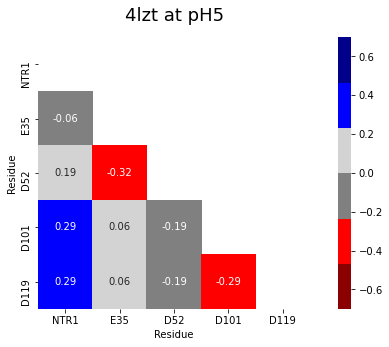

In [20]:
from matplotlib.colors import LinearSegmentedColormap,ListedColormap
df1 = all_crg_count_corr.corr()
plt.figure(figsize=(10, 5))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df1, dtype=np.bool))
cmap = ListedColormap(["darkred", "red", "gray", "lightgray", "blue", 'darkblue'])
heatmap = sns.heatmap(df1, mask=mask, vmin=-0.7, vmax=0.7, annot=True, cmap=cmap, square = True)
heatmap.set_title('4lzt at pH5', fontdict={'fontsize':18}, pad=16)
sns.set(font_scale=1.4)
plt.savefig("corr_4lzt_pH5_high_occ.pdf", dpi = 600, bbox_inches = 'tight');
